# **Expectation-Maximization algorithm** (hidden model)
### Author: Martí Cortada Garcia
---

In [55]:
# Import required libraries
import numpy as np
from Bio import SeqIO, Phylo
from io import StringIO
from collections import Counter, OrderedDict
import itertools
import pandas as pd
import math
import copy

# Import required functions from modules we have programmed
from data_simulation import simulate

### **Input:**
We have a tree $T$ (where the root corresponds to the internal node codified as `Int_0`) and the alignments of the leaves.

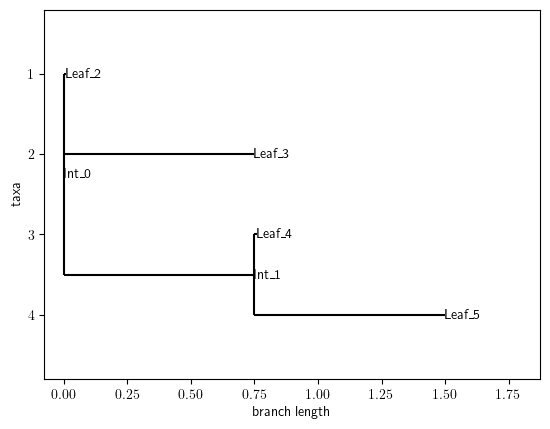

In [57]:
newick_tree = open("./newick2.txt", "r")
newick = newick_tree.read()
newick_tree.close()
tree = Phylo.read(StringIO(newick), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [13]:
# Check the theoretical parameters:
theoretical_matrices = dict()
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    u = edges[i].edge[0].name.split("_")[1]
    v = edges[i].edge[1].name.split("_")[1]
    matrix_name = "M_" + u + "_to_" + v
    print("Transition matrix:", edges[i].transition_matrix)
    theoretical_matrices[matrix_name] = np.array(edges[i].transition_matrix)
    print("---"*30)

print("Root distribution:", node_distr['Int_0'])

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix: [[0.64642183 0.02803076 0.27483013 0.05071728]
 [0.03848122 0.7757021  0.10189982 0.08391686]
 [0.03184807 0.07934462 0.82109495 0.06771236]
 [0.04702478 0.01879095 0.04076404 0.89342023]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix: [[0.55850753 0.13612552 0.2499751  0.05539185]
 [0.01791204 0.82605787 0.05907209 0.096958  ]
 [0.04534628 0.008074   0.85149918 0.09508054]
 [0.00646156 0.06355415 0.02348564 0.90649866]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix: [[0.75152183 0.09827146 0.07355421 0.0766525 ]
 [0.04888819 0.86735324 0.02989229 0.05386628]
 [0.05446854 0.02450495 0.75018255 0.17084396]
 [0.12039713 0.03979299 0.05715314 0

0.6464218290229772

In [18]:
# # save the dictionary to a file
# np.save('data.npy', theoretical_matrices)
# # load the dictionary from the file
# loaded_dict = np.load('data.npy', allow_pickle=True).item()
# # print the loaded dictionary
# print(loaded_dict)

{'M_0_to_2': array([[0.64642183, 0.02803076, 0.27483013, 0.05071728],
       [0.03848122, 0.7757021 , 0.10189982, 0.08391686],
       [0.03184807, 0.07934462, 0.82109495, 0.06771236],
       [0.04702478, 0.01879095, 0.04076404, 0.89342023]]), 'M_0_to_3': array([[0.55850753, 0.13612552, 0.2499751 , 0.05539185],
       [0.01791204, 0.82605787, 0.05907209, 0.096958  ],
       [0.04534628, 0.008074  , 0.85149918, 0.09508054],
       [0.00646156, 0.06355415, 0.02348564, 0.90649866]]), 'M_0_to_1': array([[0.75152183, 0.09827146, 0.07355421, 0.0766525 ],
       [0.04888819, 0.86735324, 0.02989229, 0.05386628],
       [0.05446854, 0.02450495, 0.75018255, 0.17084396],
       [0.12039713, 0.03979299, 0.05715314, 0.78265675]]), 'M_1_to_4': array([[0.82835309, 0.03976936, 0.05146899, 0.08040856],
       [0.02327998, 0.80873654, 0.06043788, 0.10754561],
       [0.11544022, 0.13895831, 0.71027209, 0.03532938],
       [0.09988558, 0.08065349, 0.01737091, 0.80209001]]), 'M_1_to_5': array([[0.78296278,

In [19]:
# Check the estimated parameters:
for i in params.items():
    print(i[0])
    print("Edge:", i[1].edge)
    print("Transition matrix:\n", i[1].transition_matrix)
    print("---"*30)

print("Root distribution:", root_distr)

M_0_to_2
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix:
 [[0.86753892 0.05213542 0.06946348 0.01086218]
 [0.08065343 0.85671968 0.04982893 0.01279796]
 [0.11219846 0.17464684 0.65461785 0.05853685]
 [0.02775028 0.08494961 0.04088151 0.8464186 ]]
------------------------------------------------------------------------------------------
M_0_to_3
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix:
 [[0.75527498 0.04249873 0.00019955 0.20202674]
 [0.10446698 0.73349645 0.10777451 0.05426206]
 [0.009178   0.09167603 0.88105832 0.01808765]
 [0.10672648 0.08298123 0.01949473 0.79079756]]
------------------------------------------------------------------------------------------
M_0_to_1
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix:
 [[0.69009493 0.15321495 0.12518281 0.03150731]
 [0.03390489 0.89612499 0.03748613 0.032484  ]
 [0.13612944 0.00355591 0.86031238 0.00000227]
 [0.13

In [20]:
# Compute the matrix difference between the theoretical and estimated parameters
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    print("Transition matrix difference:\n", np.abs(edges[i].transition_matrix - params['M_' + str(edges[i].edge[0].name.split("_")[1]) + '_to_' + str(edges[i].edge[1].name.split("_")[1])].transition_matrix))
    print("---"*30)

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix difference:
 [[0.09960865 0.07093256 0.00498621 0.03366231]
 [0.01576357 0.02703813 0.00892483 0.03387688]
 [0.00533819 0.03058066 0.01301418 0.01222828]
 [0.00504287 0.04282721 0.00457214 0.05244223]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix difference:
 [[0.00386991 0.01431933 0.0324696  0.04291902]
 [0.03240956 0.00438465 0.00578344 0.03101077]
 [0.00129948 0.00595081 0.00836875 0.00111846]
 [0.00368219 0.0201782  0.01427531 0.03077132]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix difference:
 [[0.00043271 0.04586535 0.01971483 0.02571781]
 [0.04628465 0.03270525 0.01225697 0.00132243]
 [0.00405161 0.02596747 0.04979691 0.01977783]


In [7]:
print("Real pi")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/real_root_distr.npy', allow_pickle=True)
print(loaded_dict)
print("Real M")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/real_matrices.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
file = open("./OUTPUTS/EM_a45_b45_1000_random/Loglikelihood_real_param.txt", "r")
a = file.read()
file.close()
print("Loglikelihood real parameters =", a)
print("---"*30)
print("Estimated M")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/M_estimation.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
print("Estimated l")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/estimated_branch_lengths.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
print("Estimated pi")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/root_estimation.npy', allow_pickle=True)
print(loaded_dict)
print("Loglikelihood:")
loaded_dict = np.load('./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/loglikelihood.npy', allow_pickle=True)
print(loaded_dict)
print("Niter")
file = open("./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/Niter.txt", "r")
a = file.read()
file.close()
print(a)
print("TExec")
file = open("./OUTPUTS/EM_a45_b45_1000_random/RESULTS/repetition_61/TExec.txt", "r")
a = file.read()
file.close()
print(a)

Real pi
[0.26647112 0.28330114 0.20796276 0.24226498]
Real M
M_0_to_2 [[0.68952073 0.10590457 0.01798509 0.18658961]
 [0.24836601 0.55787009 0.06397662 0.12978728]
 [0.06442086 0.13036822 0.79340712 0.01180381]
 [0.14025276 0.1546986  0.06326995 0.64177869]]
M_0_to_3 [[0.52892709 0.19285074 0.13821195 0.14001022]
 [0.06213775 0.80940675 0.05954367 0.06891182]
 [0.1077278  0.02559225 0.82619825 0.0404817 ]
 [0.12979294 0.30273084 0.04160339 0.52587282]]
M_0_to_1 [[0.51499869 0.16274155 0.1037552  0.21850456]
 [0.19775315 0.71734565 0.0632208  0.0216804 ]
 [0.17418369 0.12448052 0.6522592  0.04907658]
 [0.04671546 0.05060178 0.09355264 0.80913012]]
M_1_to_4 [[0.83858447 0.01308827 0.04530716 0.1030201 ]
 [0.02236854 0.70610647 0.16838053 0.10314446]
 [0.13924891 0.06411583 0.56455207 0.23208319]
 [0.16503371 0.02539007 0.19798757 0.61158865]]
M_1_to_5 [[0.58443214 0.18794543 0.06003662 0.16758581]
 [0.12636206 0.66203793 0.07256628 0.13903373]
 [0.03941104 0.11658531 0.79293194 0.0510717

Text(0.5, 1.0, '\\TeX\\ is Number $\\displaystyle\\sum_{n=1}^\\infty\\frac{-e^{i\\pi}}{2^n}$!')

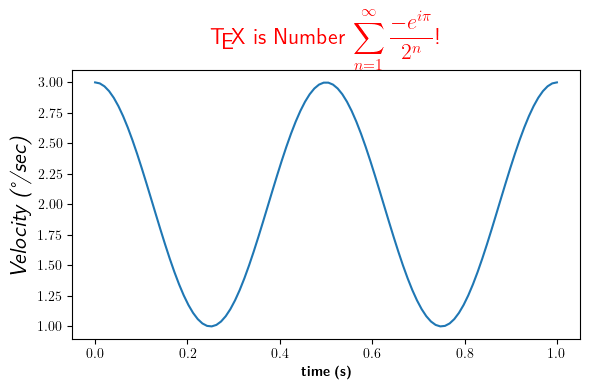

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True


t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel(r'\textbf{time (s)}')
ax.set_ylabel('\\textit{Velocity (\N{DEGREE SIGN}/sec)}', fontsize=16)
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')

In [34]:
s = np.random.dirichlet((10, 5, 3), 20).transpose()
s

array([[0.46859345, 0.45895751, 0.49718821, 0.51949561, 0.46959713,
        0.51892612, 0.73279716, 0.65655076, 0.52268771, 0.57658202,
        0.56681433, 0.64850538, 0.5045442 , 0.62646894, 0.68675087,
        0.63410837, 0.5776487 , 0.6240821 , 0.47543598, 0.68618513],
       [0.39790859, 0.17867732, 0.21366946, 0.39143257, 0.30866203,
        0.42363557, 0.18329555, 0.33096039, 0.30373377, 0.24149679,
        0.29365228, 0.22496564, 0.26863621, 0.23484876, 0.2588794 ,
        0.26888975, 0.26050767, 0.18150088, 0.22167341, 0.25037013],
       [0.13349796, 0.36236517, 0.28914232, 0.08907183, 0.22174085,
        0.05743831, 0.08390729, 0.01248884, 0.17357851, 0.18192119,
        0.13953338, 0.12652898, 0.22681959, 0.13868229, 0.05436973,
        0.09700188, 0.16184362, 0.19441702, 0.30289061, 0.06344473]])

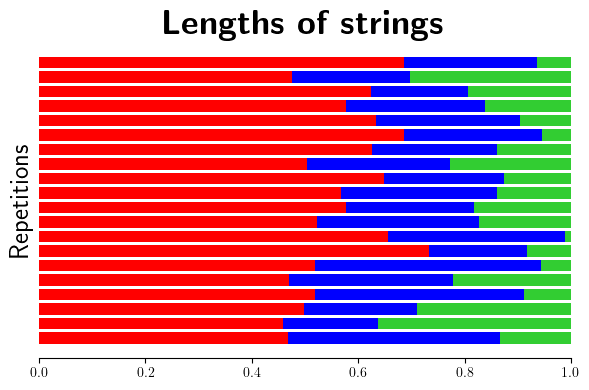

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.barh(range(20), s[0], color='r')
ax.barh(range(20), s[1], left=s[0], color='b')
ax.barh(range(20), s[2], left=s[0]+s[1], color='limegreen')
ax.set_title(r'{\Huge\textbf{Lengths of strings}}', fontsize=16)
ax.set_ylabel(r'Repetitions', fontsize=19)
ax.set_yticklabels([])
ax.set_yticks([])
# Define a x-limit axis
ax.set_xlim([0, 1])
# Hide the right and top spines
ax.spines[['right', 'top', 'left']].set_visible(False)

In [54]:
for l in [0.01, 0.15, 0.3, 0.45, 0.6, 0.75]:
    print(f"l={l}, gamma = {round((25*np.sqrt(l)*np.exp(-l/4))/(l),4)}")

l=0.01, gamma = 249.3758
l=0.15, gamma = 62.1739
l=0.3, gamma = 42.3455
l=0.45, gamma = 33.3024
l=0.6, gamma = 27.7792
l=0.75, gamma = 23.932
